# BEV to POV

In [166]:
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap

from nuscenes.utils.geometry_utils import box_in_image, view_points
from nuscenes.utils.data_classes import Box

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from pyquaternion import Quaternion
from PIL import Image
import cv2
import os


nusc = NuScenes(version='v1.0-mini', dataroot='/network/scratch/a/anthony.gosselin/nuscenes', verbose=True)
nusc_map = NuScenesMap(dataroot='/network/scratch/a/anthony.gosselin/nuscenes', map_name='singapore-hollandvillage')

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.374 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [167]:
my_scene = nusc.scene[8]  # {8: 1094,  0: 0061, 9: 1100}
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
cam_front_data = nusc.get('sample_data', my_sample['data']["CAM_FRONT"])
front_camera_sensor = nusc.get('calibrated_sensor', cam_front_data['calibrated_sensor_token'])

#### GT sensor data

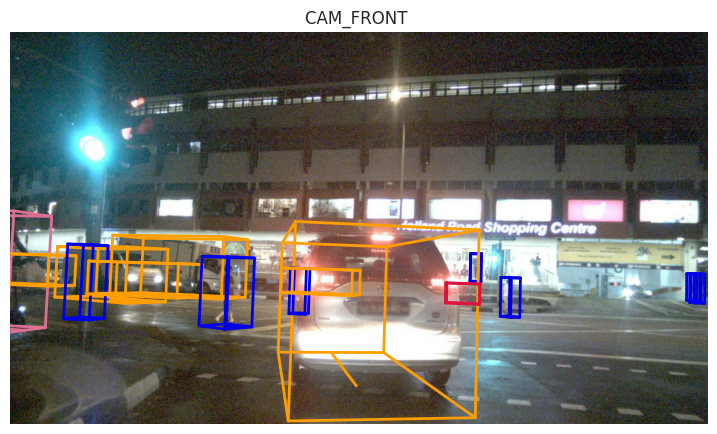

In [168]:
nusc.render_sample_data(cam_front_data['token'])

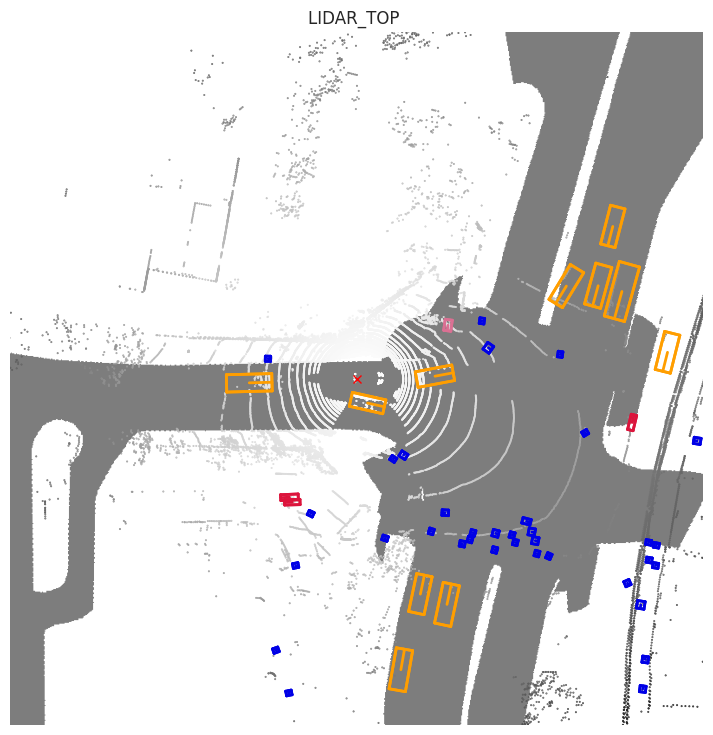

In [169]:
lidar_top_data = nusc.get('sample_data', my_sample['data']["LIDAR_TOP"])
nusc.render_sample_data(lidar_top_data['token'])

In [170]:
my_sample_data = cam_front_data

In [171]:
ego_pose = nusc.get('ego_pose', my_sample_data['ego_pose_token'])
ego_pose_2d = (ego_pose['translation'][0], ego_pose['translation'][1])

### Create 2D bboxes

In [172]:
def my_render_2d(ax, nusc, bboxes_2d, ego_pose_2d):
    
    # ax.axis('off')
    
    for bbox_2d in bboxes_2d:
        center, size, angle = bbox_2d['center'], bbox_2d['size'], bbox_2d['heading']
        color = np.array(nusc.colormap[bbox_2d['category']]) / 255

        # Calculate the bottom left corner of the rectangle
        width, length = size[0], size[1]
        bottom_left_x = center[0] - width / 2
        bottom_left_y = center[1] - length / 2

        # Create the rectangle
        rectangle = patches.Rectangle((bottom_left_x, bottom_left_y), width, length, linewidth=2, edgecolor=color, facecolor='none')
    
        # Create a transformation for rotation about the center
        t = patches.transforms.Affine2D().rotate_deg_around(center[0], center[1], np.degrees(angle - np.pi/2))
        
        # Apply the transformation to the rectangle
        rectangle.set_transform(t + ax.transData)
        
        # Add the rectangle to the plot
        ax.add_patch(rectangle)

        # Calculate the orientation line
        front_center_x = center[0] + (length / 2) * np.cos(angle)
        front_center_y = center[1] + (length / 2) * np.sin(angle)

        # Plot the orientation line
        ax.plot([center[0], front_center_x], [center[1], front_center_y], color=color, linewidth=2)
    
    ax.relim()
    ax.autoscale_view()

    # Show ego vehicle.
    ax.plot(ego_pose_2d[0], ego_pose_2d[1], 'x', color='red')

    # Ensure the aspect ratio is equal to prevent distortion
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

#### GT

In [173]:
# _, ax = plt.subplots(1, 1, figsize=(8, 8))

# for ann_token in my_sample['anns']:
#     bbox_3d = nusc.get_box(ann_token)
#     color = np.array(nusc.colormap[bbox_3d.name]) / 255
#     bbox_3d.render(axis=ax, view=np.eye(4), colors=(color, color, color))

# ax.relim()
# ax.autoscale_view()
# plt.gca().set_aspect('equal', adjustable='box')
# # ax.axis('off')

# # Show ego vehicle.
# ax.plot(ego_pose_2d[0], ego_pose_2d[1], 'x', color='red')

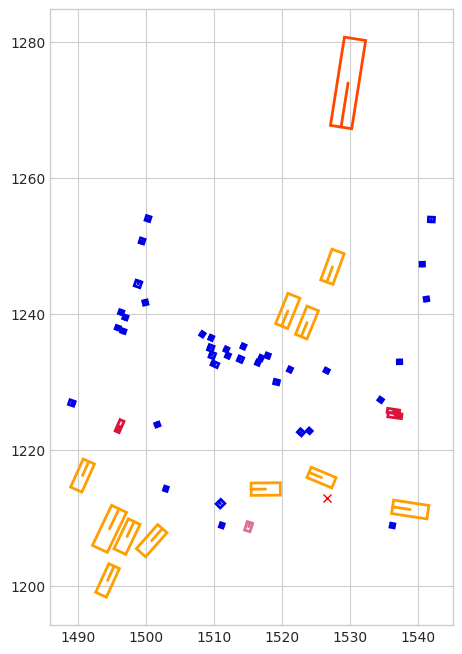

In [174]:
bboxes_2d = []
bboxes_3d = []
for ann_token in my_sample['anns']:
    bbox_3d = nusc.get_box(ann_token)
    bboxes_3d.append(bbox_3d)
    yaw, pitch, roll  = bbox_3d.orientation.yaw_pitch_roll
    annotation_data = nusc.get('sample_annotation', ann_token)
    bbox_2d = {'center': [bbox_3d.center[0], bbox_3d.center[1]], 'size': [bbox_3d.wlh[0], bbox_3d.wlh[1]], 'heading': yaw, 'category': bbox_3d.name, 'instance_token': annotation_data['instance_token']}

    # print(f"og rot: {bbox_3d.orientation}, yaw: {yaw}, heading: {bbox_2d['heading']}, reconstructed: {Quaternion._from_axis_angle(np.array([0, 0, 1]), bbox_2d['heading'])}")
    bboxes_2d.append(bbox_2d)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
my_render_2d(ax, nusc, bboxes_2d, ego_pose_2d)

### Reconstruct 3D bboxes

In [175]:
nusc.list_categories()

Category stats for split v1.0-mini:
human.pedestrian.adult      n= 4765, width= 0.68±0.11, len= 0.73±0.17, height= 1.76±0.12, lw_aspect= 1.08±0.23
human.pedestrian.child      n=   46, width= 0.46±0.08, len= 0.45±0.09, height= 1.37±0.06, lw_aspect= 0.97±0.05
human.pedestrian.constructi n=  193, width= 0.69±0.07, len= 0.74±0.12, height= 1.78±0.05, lw_aspect= 1.07±0.16
human.pedestrian.personal_m n=   25, width= 0.83±0.00, len= 1.28±0.00, height= 1.87±0.00, lw_aspect= 1.55±0.00
human.pedestrian.police_off n=   11, width= 0.59±0.00, len= 0.47±0.00, height= 1.81±0.00, lw_aspect= 0.80±0.00
movable_object.barrier      n= 2323, width= 2.32±0.49, len= 0.61±0.11, height= 1.06±0.10, lw_aspect= 0.28±0.09
movable_object.debris       n=   13, width= 0.43±0.00, len= 1.43±0.00, height= 0.46±0.00, lw_aspect= 3.35±0.00
movable_object.pushable_pul n=   82, width= 0.51±0.06, len= 0.79±0.10, height= 1.04±0.20, lw_aspect= 1.55±0.18
movable_object.trafficcone  n= 1378, width= 0.47±0.14, len= 0.45±0.07, heigh

In [176]:
def get_random_height(category: str):
    heights_by_category = {
        "human.pedestrian.adult": {"mean": 1.76, "std": 0.12},
        "human.pedestrian.child":  {"mean": 1.37, "std": 0.06},
        "human.pedestrian.construction_worker": {"mean": 1.78, "std": 0.05},
        "human.pedestrian.personal_mobility": {"mean": 1.87, "std": 0.00},
        "human.pedestrian.police_officer": {"mean": 1.81, "std": 0.00},
        "movable_object.barrier": {"mean": 1.06, "std": 0.10},
        "movable_object.debris":  {"mean": 0.46, "std": 0.00},
        "movable_object.pushable_pullable": {"mean": 1.04, "std": 0.20},
        "movable_object.trafficcone": {"mean": 0.78, "std": 0.13},
        "static_object.bicycle_rack":  {"mean": 1.40, "std": 0.00},
        "vehicle.bicycle":  {"mean": 1.39, "std": 0.34},
        "vehicle.bus.bendy":  {"mean": 3.32, "std": 0.07},
        "vehicle.bus.rigid":  {"mean": 3.80, "std": 0.62},
        "vehicle.car": {"mean": 1.69, "std": 0.21},
        "vehicle.construction":  {"mean": 2.38, "std": 0.33},
        "vehicle.motorcycle":  {"mean": 1.47, "std": 0.20},
        "vehicle.trailer":  {"mean": 3.71, "std": 0.27},
        "vehicle.truck":  {"mean": 2.62, "std": 0.68},
    }

    stats = heights_by_category[category]
    height = np.random.normal(stats['mean'], stats['std'])

    return height

In [177]:
front_camera_sensor

{'token': '7ce942240a1f4e349c4c3c64d7b258b5',
 'sensor_token': '725903f5b62f56118f4094b46a4470d8',
 'translation': [1.70079118954, 0.0159456324149, 1.51095763913],
 'rotation': [0.4998015430569128,
  -0.5030316162024876,
  0.4997798114386805,
  -0.49737083824542755],
 'camera_intrinsic': [[1266.417203046554, 0.0, 816.2670197447984],
  [0.0, 1266.417203046554, 491.50706579294757],
  [0.0, 0.0, 1.0]]}

#### Rendering code

In [178]:
def render_box_3d(box, axis, view: np.ndarray = np.eye(3), normalize: bool = False, colors = ('b', 'r', 'k'), linewidth: float = 2) -> None:
        """
        Renders the box in the provided Matplotlib axis.
        :param axis: Axis onto which the box should be drawn.
        :param view: <np.array: 3, 3>. Define a projection in needed (e.g. for drawing projection in an image).
        :param normalize: Whether to normalize the remaining coordinate.
        :param colors: (<Matplotlib.colors>: 3). Valid Matplotlib colors (<str> or normalized RGB tuple) for front,
            back and sides.
        :param linewidth: Width in pixel of the box sides.
        """
        corners = view_points(box.corners(), view, normalize=normalize)[:2, :]

        def draw_rect(selected_corners, color):
            prev = selected_corners[-1]
            for corner in selected_corners:
                axis.plot([prev[0], corner[0]], [prev[1], corner[1]], color=color, linewidth=linewidth)
                prev = corner

        # Draw the sides
        for i in range(4):
            axis.plot([corners.T[i][0], corners.T[i + 4][0]],
                      [corners.T[i][1], corners.T[i + 4][1]],
                      color=colors[2], linewidth=linewidth)

        # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
        draw_rect(corners.T[:4], colors[0])
        draw_rect(corners.T[4:], colors[1])

        # Draw line indicating the front
        # center_bottom_forward = np.mean(corners.T[2:4], axis=0)
        # center_bottom = np.mean(corners.T[[2, 3, 7, 6]], axis=0)
        # axis.plot([center_bottom[0], center_bottom_forward[0]],
        #           [center_bottom[1], center_bottom_forward[1]],
        #           color=colors[0], linewidth=linewidth)
        
        # Draw x mark at the back of the object
        axis.plot([corners.T[4][0], corners.T[6][0], corners.T[5][0], corners.T[7][0]],
                  [corners.T[4][1], corners.T[6][1], corners.T[5][1], corners.T[7][1]],
                  color=colors[0], linewidth=1)
        
def my_render_3d(ax, nusc, boxes_3d, camera_sensor, ego_pose, data_path=None, transform=True, background=False) -> None:
    """
    Bboxes are to be in global coordinate frame, and will be projected to the specified camera
    """

    # Plot CAMERA view.
    im_size = (1600, 900) if data_path is None else Image.open(data_path).size
    ax.set_xlim(0, im_size[0])
    ax.set_ylim(im_size[1], 0)
    ax.set_aspect('equal')

    if background:
        im = Image.new('RGB', im_size) if not data_path else Image.open(data_path)
        ax.imshow(im)
        ax.axis('off')
    
    # Camera extrinsic and intrinsic parameters
    camera_intrinsic = np.array(camera_sensor['camera_intrinsic'])

    for box_3d in boxes_3d:
        
        if transform:
            # Move box to ego vehicle coord system.
            box_3d.translate(-np.array(ego_pose['translation']))
            box_3d.rotate(Quaternion(ego_pose['rotation']).inverse)
            #  Move box to sensor coord system.
            box_3d.translate(-np.array(camera_sensor['translation']))
            box_3d.rotate(Quaternion(camera_sensor['rotation']).inverse)

        # Only render bboxes that fit in image frame
        if not box_in_image(box_3d, camera_intrinsic, im_size, vis_level=1):
            continue
            
        c = np.array(nusc.colormap[box_3d.name]) / 255.0
        render_box_3d(box_3d, ax, view=camera_intrinsic, normalize=True, colors=(c, c, c))

        # if "personal_mobility" in box_3d.name:
        # print("Convert to local:", box_3d)

#### GT

In [179]:
# # GT
# front_cam_token = my_sample['data']['CAM_FRONT']
# data_path, bboxes_3d_local, camera_intrinsic = nusc.get_sample_data(front_cam_token, selected_anntokens=my_sample['anns'])
# fig, ax = plt.subplots(1, 1, figsize=(9, 9))
# my_render_3d(ax, nusc, bboxes_3d_local, front_camera_sensor, ego_pose, data_path, transform=False)

#### Reconstruction

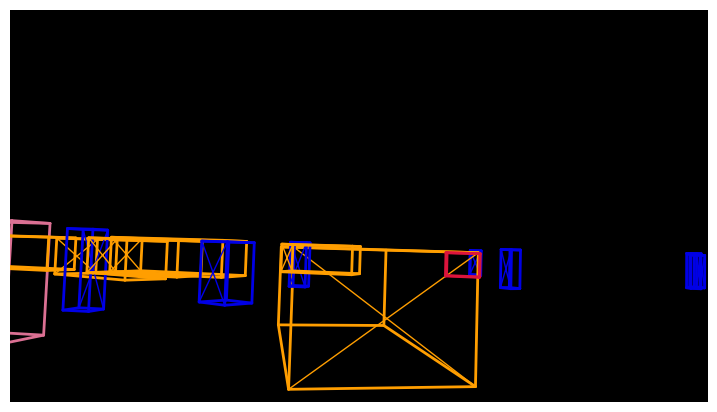

In [180]:
ego_height = get_random_height('vehicle.car')

bboxes_3d_out = []
for bbox_2d in bboxes_2d:
    center = [bbox_2d['center'][0], bbox_2d['center'][1], ego_height/2] # Adjust height because sensor is mounted on ego (And we don't have z-height information)
    size = [bbox_2d['size'][0], bbox_2d['size'][1], get_random_height(bbox_2d['category'])]
    orientation = Quaternion._from_axis_angle(np.array([0, 0, 1]), bbox_2d['heading'])
    bbox_3d = Box(center, size, orientation, name=bbox_2d['category'])
    bboxes_3d_out.append(bbox_3d)

# print("Original: ", bboxes_3d[1])
# print("2D       :", bboxes_2d[1])
# print("Converted:", bboxes_3d_out[1])

front_cam_token = my_sample['data']['CAM_FRONT']
_, _, camera_intrinsic = nusc.get_sample_data(front_cam_token, selected_anntokens=[])

fig, ax = plt.subplots(1, 1, figsize=(9, 9))
my_render_3d(ax, nusc, bboxes_3d_out, front_camera_sensor, ego_pose, data_path=None, background=True)

#### GT with image

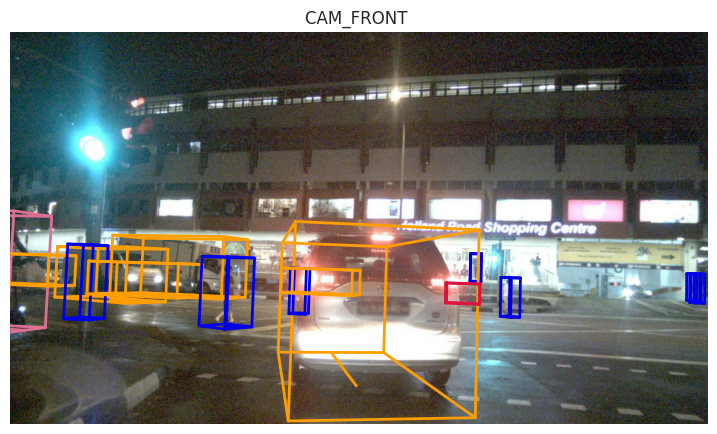

In [181]:
nusc.render_sample_data(cam_front_data['token'])

### Generate bbox sequences

In [182]:
my_scene

{'token': 'de7d80a1f5fb4c3e82ce8a4f213b450a',
 'log_token': '8fefc430cbfa4c2191978c0df302eb98',
 'nbr_samples': 40,
 'first_sample_token': 'e6b0b282aa174a978272dc2d0a89d560',
 'last_sample_token': '4e1d1031fe9f45f981a2f598365fc645',
 'name': 'scene-1094',
 'description': 'Night, after rain, many peds, PMD, ped with bag, jaywalker, truck, scooter'}

#### Create 2D bbox sequence

In [183]:
bboxes_2d_seq = []
ego_pose_seq = []
ind = 0
curr_sample = my_sample
next_sample_token = curr_sample['token']

while True:
    curr_sample = nusc.get('sample', next_sample_token)
    bboxes_2d_seq.append([])
    
    # The sequence of ego poses determines the trajectory of the camera through the reconstructed scene
    # (This means we can move the camera as we please through the reconstructed scene)
    curr_cam_front_data = nusc.get('sample_data', curr_sample['data']["CAM_FRONT"])
    ego_pose_seq.append(nusc.get('ego_pose', curr_cam_front_data['ego_pose_token']))

    for ann_token in curr_sample['anns']:
        bbox_3d = nusc.get_box(ann_token)
        yaw, pitch, roll  = bbox_3d.orientation.yaw_pitch_roll
        annotation_data = nusc.get('sample_annotation', ann_token)
        bbox_2d = {'center': [bbox_3d.center[0], bbox_3d.center[1]], 'size': [bbox_3d.wlh[0], bbox_3d.wlh[1]], 'heading': yaw, 'category': bbox_3d.name, 'instance_token': annotation_data['instance_token']}
        bboxes_2d_seq[ind].append(bbox_2d)
    
    ind += 1
    next_sample_token = curr_sample['next']
    if next_sample_token == '':
        break
    
print("Sequence length:", len(bboxes_2d_seq))

Sequence length: 40


#### Reconstruct 3D bbox sequence

In [184]:
ego_height = get_random_height('vehicle.car')
front_cam_token = my_sample['data']['CAM_FRONT']
agent_heights = {}

# Parameters for the video
video_filename = f"video_out/{my_scene['name']}.avi"
fps = 5  # NOTE Real time is 2 fps
frame_size = (640*2, 480*2)

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer_out = cv2.VideoWriter(video_filename, fourcc, fps, frame_size)
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
plt.tight_layout(pad=0)

for t, bboxes_2d_t in enumerate(bboxes_2d_seq):
    bboxes_3d_out = []
    for ind, bbox_2d in enumerate(bboxes_2d_t):
        center = [bbox_2d['center'][0], bbox_2d['center'][1], ego_height/2] # Adjust height because sensor is mounted on ego (And we don't have z-height information)
        
        agent_height = agent_heights.get(bbox_2d['instance_token'])
        if agent_height is None:
            agent_heights[bbox_2d['instance_token']] = get_random_height(bbox_2d['category'])
            agent_height = agent_heights.get(bbox_2d['instance_token'])
                       
        size = [bbox_2d['size'][0], bbox_2d['size'][1], agent_height]
        orientation = Quaternion._from_axis_angle(np.array([0, 0, 1]), bbox_2d['heading'])
        bbox_3d = Box(center, size, orientation, name=bbox_2d['category'])
        bboxes_3d_out.append(bbox_3d)

    ax.clear()
    # Update ego pose (else the POV will remain fixed in the scene)
    curr_ego_pose = ego_pose_seq[t]
    my_render_3d(ax, nusc, bboxes_3d_out, front_camera_sensor, curr_ego_pose, None, background=True)

    # Convert plot to image
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = cv2.resize(img, frame_size)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    video_writer_out.write(img)

video_writer_out.release()
print(f"Video saved: {video_filename}")
plt.close(fig)

Video saved: video_out/scene-1094.avi


#### GT 3D bbox sequence with images

In [185]:
import cv2

ego_height = get_random_height('vehicle.car')
_, _, camera_intrinsic = nusc.get_sample_data(my_sample['data']['CAM_FRONT'], selected_anntokens=[])

# Parameters for the video
video_filename = f"video_out/{my_scene['name']}_gt.avi"
fps = 7 # NOTE Real time is 2 fps
frame_size = (640*2, 480*2)

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer_out = cv2.VideoWriter(video_filename, fourcc, fps, frame_size)
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

curr_sample = my_sample
next_sample_token = curr_sample['token']

while True:
    curr_sample = nusc.get('sample', next_sample_token)

    ax.clear()
    data_path, bboxes_3d_local, camera_intrinsic = nusc.get_sample_data(curr_sample['data']['CAM_FRONT'], selected_anntokens=curr_sample['anns'])
    my_render_3d(ax, nusc, bboxes_3d_local, front_camera_sensor, ego_pose, data_path, transform=False, background=True)

    # Convert plot to image
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = cv2.resize(img, frame_size)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    video_writer_out.write(img)

    next_sample_token = curr_sample['next']
    if next_sample_token == '':
        break

video_writer_out.release()
print(f"Video saved: {video_filename}")
plt.close(fig)

Video saved: video_out/scene-1094_gt.avi


### Exporting to Ctrl-V

#### Trying with CV2 instead of matplotlib

In [186]:
def render_box_3d_CV(box, img, view: np.ndarray = np.eye(3), normalize: bool = False, colors = ((255, 0, 0), (0, 0, 255), (0, 0, 0)), thickness: int = 2) -> None:
    """
    Renders the box in the provided image using OpenCV.
    :param img: Image onto which the box should be drawn.
    :param view: <np.array: 3, 3>. Define a projection if needed (e.g., for drawing projection in an image).
    :param normalize: Whether to normalize the remaining coordinate.
    :param colors: (<tuple>: 3). Valid OpenCV colors (<tuple of BGR>) for front, back, and sides.
    :param thickness: Thickness in pixels of the box sides.
    """
    corners = view_points(box.corners(), view, normalize=normalize)[:2, :]

    def draw_rect(selected_corners, color):
        prev = selected_corners[-1]
        for corner in selected_corners:
            cv2.line(img, tuple(prev.astype(int)), tuple(corner.astype(int)), color, thickness)
            prev = corner

    # Draw the sides
    for i in range(4):
        cv2.line(img, tuple(corners.T[i][:2].astype(int)), tuple(corners.T[i + 4][:2].astype(int)), colors[2], thickness)

    # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
    draw_rect(corners.T[:4], colors[0])
    draw_rect(corners.T[4:], colors[1])

    # Draw line indicating the front
    # center_bottom_forward = np.mean(corners.T[2:4], axis=0)
    # center_bottom = np.mean(corners.T[[2, 3, 7, 6]], axis=0)
    # cv2.line(img, tuple(center_bottom.astype(int)), tuple(center_bottom_forward.astype(int)), colors[0], thickness)

    # Draw x mark at the back of the object
    cv2.line(img, tuple(corners.T[4][:2].astype(int)), tuple(corners.T[6][:2].astype(int)), colors[0], 1)
    cv2.line(img, tuple(corners.T[5][:2].astype(int)), tuple(corners.T[7][:2].astype(int)), colors[0], 1)

def my_render_3d_CV(img, nusc, boxes_3d, camera_sensor, ego_pose, data_path=None, transform=True, background=False) -> None:
    """
    Bboxes are to be in global coordinate frame, and will be projected to the specified camera
    """

    # Camera extrinsic and intrinsic parameters
    camera_intrinsic = np.array(camera_sensor['camera_intrinsic'])

    for box_3d in boxes_3d:
        
        if transform:
            # Move box to ego vehicle coord system.
            box_3d.translate(-np.array(ego_pose['translation']))
            box_3d.rotate(Quaternion(ego_pose['rotation']).inverse)
            #  Move box to sensor coord system.
            box_3d.translate(-np.array(camera_sensor['translation']))
            box_3d.rotate(Quaternion(camera_sensor['rotation']).inverse)

        # Only render bboxes that fit in image frame
        if not box_in_image(box_3d, camera_intrinsic, (img.shape[1], img.shape[0]), vis_level=1):
            continue

        c = np.array(nusc.colormap[box_3d.name]) / 255.0
        render_box_3d_CV(box_3d, img, view=camera_intrinsic, normalize=True, colors=(c, c, c))

        # if "personal_mobility" in box_3d.name:
        # print("Convert to local:", box_3d)

In [187]:
ego_height = get_random_height('vehicle.car')

bboxes_3d_out = []
for bbox_2d in bboxes_2d:
    center = [bbox_2d['center'][0], bbox_2d['center'][1], ego_height/2] # Adjust height because sensor is mounted on ego (And we don't have z-height information)
    size = [bbox_2d['size'][0], bbox_2d['size'][1], get_random_height(bbox_2d['category'])]
    orientation = Quaternion._from_axis_angle(np.array([0, 0, 1]), bbox_2d['heading'])
    bbox_3d = Box(center, size, orientation, name=bbox_2d['category'])
    bboxes_3d_out.append(bbox_3d)


front_cam_token = my_sample['data']['CAM_FRONT']
_, _, camera_intrinsic = nusc.get_sample_data(front_cam_token, selected_anntokens=[])


img = np.ones((900, 1600, 3)) * 255
my_render_3d_CV(img, nusc, bboxes_3d_out, front_camera_sensor, ego_pose, data_path=None, background=True)

img = cv2.resize(img, (512, 320))
cv2.imwrite("images/image_out.jpg", img)


True

#### With Matplotlib

##### Color definitions

In [188]:
from collections import defaultdict

class CVCOLORS:
    RED = (0,0,255)
    GREEN = (0,255,0)
    BLUE = (255,0,0)
    PURPLE = (247,44,200)
    ORANGE = (44,162,247)
    MINT = (239,255,66)
    YELLOW = (2,255,250)
    BROWN = (42,42,165)
    LIME=(51,255,153)
    GRAY=(128, 128, 128)
    LIGHTPINK = (222,209,255)
    LIGHTGREEN = (204,255,204)
    LIGHTBLUE = (255,235,207)
    LIGHTPURPLE = (255,153,204)
    LIGHTRED = (204,204,255)
    WHITE = (255,255,255)
    BLACK = (0,0,0)
    
    TRACKID_LOOKUP = defaultdict(lambda: (np.random.randint(50, 255), np.random.randint(50, 255), np.random.randint(50, 255)))
    TYPE_LOOKUP = [BLUE, WHITE, RED, YELLOW, PURPLE, BROWN, GREEN, ORANGE, LIGHTPURPLE, LIGHTRED, GRAY]
    REVERT_CHANNEL_F = lambda x: (x[2], x[1], x[0])

In [189]:
# Based on closest match to KITTI classes
NUSC_CLASS_TO_GROUP_IDS_KITTI = {
    "human.pedestrian.adult": 4,
    "human.pedestrian.child":  4,
    "human.pedestrian.construction_worker": 5,
    "human.pedestrian.personal_mobility": 4,
    "human.pedestrian.police_officer": 5,
    "movable_object.barrier": 8,
    "movable_object.debris":  8,
    "movable_object.pushable_pullable": 8,
    "movable_object.trafficcone": 8,
    "static_object.bicycle_rack":  8,
    "vehicle.bicycle":  6,
    "vehicle.bus.bendy":  3,
    "vehicle.bus.rigid":  3,
    "vehicle.car": 1,
    "vehicle.construction":  3,
    "vehicle.motorcycle":  6,  # NOTE: Not sure if best to classify as cyclist or car...
    "vehicle.trailer":  3,
    "vehicle.truck":  3,
}

# KITTI:
# IDS_CLASS_LOOKUP = {
#     1: 'Car',
#     2: 'Van',
#     3: 'Truck',
#     4: 'Pedestrian',
#     5: 'Person',
#     6: 'Cyclist',
#     7: 'Tram',
#     8: 'Misc',
#     9: 'DontCare'
# }

# Based on closest match to BDD100k classes
NUSC_CLASS_TO_GROUP_IDS_BDD = {
    "human.pedestrian.adult": 1,
    "human.pedestrian.child":  1,
    "human.pedestrian.construction_worker": 1,
    "human.pedestrian.personal_mobility": 1,
    "human.pedestrian.police_officer": 1,
    "movable_object.barrier": 10,
    "movable_object.debris":  10,
    "movable_object.pushable_pullable": 10,
    "movable_object.trafficcone": 10,
    "static_object.bicycle_rack":  10,
    "vehicle.bicycle":  8,
    "vehicle.bus.bendy":  5,
    "vehicle.bus.rigid":  5,
    "vehicle.car": 3,
    "vehicle.construction":  4,
    "vehicle.motorcycle":  7, 
    "vehicle.trailer":  4,
    "vehicle.truck":  4,
}

# BDD100k:
# IDS_CLASS_LOOKUP = {
#         1: 'pedestrian',
#         2: 'rider',
#         3: 'car',
#         4: 'truck',
#         5: 'bus',
#         6: 'train',
#         7: 'motorcycle',
#         8: 'bicycle',
#         9: 'traffic light',
#         10: 'traffic sign',
#     }

NUSC_CLASS_TO_GROUP_IDS = NUSC_CLASS_TO_GROUP_IDS_BDD


#####

In [190]:
def render_box_3d_style(box, axis, view: np.ndarray = np.eye(3), normalize: bool = False, outline_color=(255, 0, 0), fill_color=(0, 255, 0), linewidth: float = 2, show_3d_bboxes=True, show_2d_bboxes=False) -> None:
        """
        Renders the box in the provided Matplotlib axis.
        :param axis: Axis onto which the box should be drawn.
        :param view: <np.array: 3, 3>. Define a projection in needed (e.g. for drawing projection in an image).
        :param normalize: Whether to normalize the remaining coordinate.
        :param colors: (<Matplotlib.colors>: 3). Valid Matplotlib colors (<str> or normalized RGB tuple) for front,
            back and sides.
        :param linewidth: Width in pixel of the box sides.
        """
        corners = view_points(box.corners(), view, normalize=normalize)[:2, :]

        if show_3d_bboxes:
            def draw_rect(selected_corners, color):
                prev = selected_corners[-1]
                for corner in selected_corners:
                    axis.plot([prev[0], corner[0]], [prev[1], corner[1]], color=color, linewidth=linewidth)
                    prev = corner

            # Draw the sides
            for i in range(4):
                axis.plot([corners.T[i][0], corners.T[i + 4][0]],
                        [corners.T[i][1], corners.T[i + 4][1]],
                        color=outline_color, linewidth=linewidth)

            # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
            draw_rect(corners.T[:4], outline_color)
            draw_rect(corners.T[4:], outline_color)

            # Draw line indicating the front
            # center_bottom_forward = np.mean(corners.T[2:4], axis=0)
            # center_bottom = np.mean(corners.T[[2, 3, 7, 6]], axis=0)
            # axis.plot([center_bottom[0], center_bottom_forward[0]],
            #           [center_bottom[1], center_bottom_forward[1]],
            #           color=colors[0], linewidth=linewidth)
            
            # Draw x mark at the back of the object
            axis.plot([corners.T[4][0], corners.T[6][0], corners.T[5][0], corners.T[7][0]],
                    [corners.T[4][1], corners.T[6][1], corners.T[5][1], corners.T[7][1]],
                    color=outline_color, linewidth=1)

        if show_2d_bboxes:
            # Calculate the bottom left corner of the rectangle
            bottom_left_x, top_right_x = np.min(corners.T[:, 0]), np.max(corners.T[:, 0])
            bottom_left_y, top_right_y = np.min(corners.T[:, 1]), np.max(corners.T[:, 1])
            width, height = np.abs(bottom_left_x - top_right_x), np.abs(bottom_left_y - top_right_y)

            # Create the rectangle
            edgecolor = 'none' if show_3d_bboxes else outline_color
            rectangle = patches.Rectangle((bottom_left_x, bottom_left_y), width, height, linewidth=2, edgecolor=edgecolor, facecolor=fill_color, alpha=0.75)
            ax.add_patch(rectangle)
            
        
def my_render_3d_style(ax, nusc, boxes_3d, camera_sensor, ego_pose, data_path=None, transform=True, background=False, show_3d_bboxes=True, show_2d_bboxes=False) -> None:
    """
    Bboxes are to be in global coordinate frame, and will be projected to the specified camera
    """

    # Plot CAMERA view.
    im_size = (1600, 900) if data_path is None else Image.open(data_path).size
    ax.set_xlim(0, im_size[0])
    ax.set_ylim(im_size[1], 0)
    ax.set_aspect('equal')

    if background:
        im = Image.new('RGB', im_size) if not data_path else Image.open(data_path)
        ax.imshow(im)
        ax.axis('off')
    
    # Camera extrinsic and intrinsic parameters
    camera_intrinsic = np.array(camera_sensor['camera_intrinsic'])

    for ind, box_3d in enumerate(boxes_3d):
        
        if transform:
            # Move box to ego vehicle coord system.
            box_3d.translate(-np.array(ego_pose['translation']))
            box_3d.rotate(Quaternion(ego_pose['rotation']).inverse)
            #  Move box to sensor coord system.
            box_3d.translate(-np.array(camera_sensor['translation']))
            box_3d.rotate(Quaternion(camera_sensor['rotation']).inverse)

        # Only render bboxes that fit in image frame
        if not box_in_image(box_3d, camera_intrinsic, im_size, vis_level=1):
            continue
            
        outline_color = np.array(CVCOLORS.REVERT_CHANNEL_F(CVCOLORS.TYPE_LOOKUP[NUSC_CLASS_TO_GROUP_IDS[box_3d.name]])) / 255.0
        # fill_color = np.array(CVCOLORS.REVERT_CHANNEL_F(CVCOLORS.TRACKID_LOOKUP[box_3d.token])) / 255.0
        instance_token = box_3d.token
        if not transform:
            annotation_data = nusc.get('sample_annotation', box_3d.token)
            instance_token = annotation_data['instance_token']
        fill_color = np.array(CVCOLORS.REVERT_CHANNEL_F(CVCOLORS.TRACKID_LOOKUP[instance_token])) / 255.0
        
        render_box_3d_style(box_3d, ax, view=camera_intrinsic, normalize=True, outline_color=outline_color, fill_color=fill_color, show_3d_bboxes=show_3d_bboxes, show_2d_bboxes=show_2d_bboxes)

        # if "personal_mobility" in box_3d.name:
        #     print(box_3d.name, instance_token)

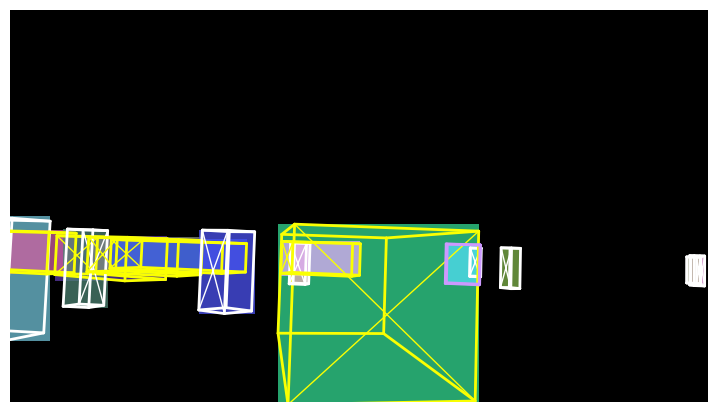

In [210]:
ego_height = get_random_height('vehicle.car')

bboxes_3d_out = []
for bbox_2d in bboxes_2d:
    center = [bbox_2d['center'][0], bbox_2d['center'][1], ego_height/2] # Adjust height because sensor is mounted on ego (And we don't have z-height information)
    size = [bbox_2d['size'][0], bbox_2d['size'][1], get_random_height(bbox_2d['category'])]
    orientation = Quaternion._from_axis_angle(np.array([0, 0, 1]), bbox_2d['heading'])
    bbox_3d = Box(center, size, orientation, name=bbox_2d['category'], token=bbox_2d['instance_token'])
    bboxes_3d_out.append(bbox_3d)

front_cam_token = my_sample['data']['CAM_FRONT']
_, _, camera_intrinsic = nusc.get_sample_data(front_cam_token, selected_anntokens=[])

fig, ax = plt.subplots(1, 1, figsize=(9, 9))
my_render_3d_style(ax, nusc, bboxes_3d_out, front_camera_sensor, ego_pose, data_path=None, background=True, show_2d_bboxes=True, show_3d_bboxes=True)

#### Video render

In [211]:
from torchvision import transforms
import torch

ego_height = get_random_height('vehicle.car')
front_cam_token = my_sample['data']['CAM_FRONT']
agent_heights = {}

# Parameters for the video
video_filename = f"video_out/{my_scene['name']}_style.avi"
FPS = 7  # NOTE Real time is 2 fps
frame_size = (512, 320)

transform=transforms.Compose([
                    transforms.Resize((frame_size[1], frame_size[0])),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), # map from [0,1] to [-1,1]
                 ])

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer_out = cv2.VideoWriter(video_filename, fourcc, FPS, frame_size)
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
plt.tight_layout(pad=0)

img_seq = torch.zeros([len(bboxes_2d_seq), 3, frame_size[1], frame_size[0]])

for t, bboxes_2d_t in enumerate(bboxes_2d_seq):
    bboxes_3d_out = []
    for ind, bbox_2d in enumerate(bboxes_2d_t):
        center = [bbox_2d['center'][0], bbox_2d['center'][1], ego_height/2] # Adjust height because sensor is mounted on ego (And we don't have z-height information)
        
        agent_height = agent_heights.get(bbox_2d['instance_token'])
        if agent_height is None:
            agent_heights[bbox_2d['instance_token']] = get_random_height(bbox_2d['category'])
            agent_height = agent_heights.get(bbox_2d['instance_token'])
                       
        size = [bbox_2d['size'][0], bbox_2d['size'][1], agent_height]
        orientation = Quaternion._from_axis_angle(np.array([0, 0, 1]), bbox_2d['heading'])
        bbox_3d = Box(center, size, orientation, name=bbox_2d['category'], token=bbox_2d['instance_token'])
        bboxes_3d_out.append(bbox_3d)

    # fig, ax = plt.subplots(1, 1, figsize=(9, 9))
    # plt.tight_layout(pad=0)

    ax.clear()
    # Update ego pose (else the POV will remain fixed in the scene)
    curr_ego_pose = ego_pose_seq[t]
    my_render_3d_style(ax, nusc, bboxes_3d_out, front_camera_sensor, curr_ego_pose, None, background=True, show_2d_bboxes=True, show_3d_bboxes=True)
    
    # Convert plot to image
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = cv2.resize(img, frame_size)

    # Save to tensor buffer
    img_seq[t] = transform(Image.fromarray(img))

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    video_writer_out.write(img)

    # plt.show(fig)

    
video_writer_out.release()
print(f"Video saved: {video_filename}")
plt.close(fig)

Video saved: video_out/scene-1094_style.avi


#### With GT bboxes

In [200]:
# from torchvision import transforms
# import torch

# ego_height = get_random_height('vehicle.car')
# front_cam_token = my_sample['data']['CAM_FRONT']
# agent_heights = {}

# # Parameters for the video
# video_filename = f"video_out/{my_scene['name']}_style_gt.avi"
# FPS = 7  # NOTE Real time is 2 fps
# frame_size = (512, 320)

# transform=transforms.Compose([
#                     transforms.Resize((frame_size[1], frame_size[0])),
#                     transforms.ToTensor(),
#                     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), # map from [0,1] to [-1,1]
#                  ])

# # Create a VideoWriter object
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
# video_writer_out = cv2.VideoWriter(video_filename, fourcc, FPS, frame_size)
# fig, ax = plt.subplots(1, 1, figsize=(9, 9))
# plt.tight_layout(pad=0)

# img_seq_gt = torch.zeros([len(bboxes_2d_seq), 3, frame_size[1], frame_size[0]])

# curr_sample = my_sample
# next_sample_token = curr_sample['token']

# t = 0
# while True:
#     curr_sample = nusc.get('sample', next_sample_token)

#     # fig, ax = plt.subplots(1, 1, figsize=(9, 9))
#     # plt.tight_layout(pad=0)

#     ax.clear()
#     data_path, bboxes_3d_local, camera_intrinsic = nusc.get_sample_data(curr_sample['data']['CAM_FRONT'], selected_anntokens=curr_sample['anns'])
#     my_render_3d_style(ax, nusc, bboxes_3d_local, front_camera_sensor, ego_pose, data_path=data_path, transform=False, background=True, show_2d_bboxes=True, show_3d_bboxes=False)

#     # Convert plot to image
#     fig.canvas.draw()
#     img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
#     img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     img = cv2.resize(img, frame_size)

#     # Save to tensor buffer
#     img_seq_gt[t] = transform(Image.fromarray(img))
#     t += 1

#     img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#     video_writer_out.write(img)

#     # plt.show(fig)

#     next_sample_token = curr_sample['next']
#     if next_sample_token == '':
#         break

    
# video_writer_out.release()
# print(f"Video saved: {video_filename}")
# plt.close(fig)

#### 

In [212]:
# Get initial image for conditioning
image_init_path = os.path.join(nusc.dataroot, cam_front_data['filename'])
image_init = Image.open(image_init_path)
sample_out = {'bbox_img': img_seq, 'image_init': image_init}


# sample_out = {'bbox_img': img_seq_gt, 'image_init': image_init} 



#### Generate predicted video with Ctrl-V

In [213]:
import warnings
import numpy as np
import torch
torch.cuda.empty_cache()
import torch.utils.checkpoint

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from ctrlv.utils import export_to_video
    from ctrlv.pipelines import StableVideoControlPipeline

CLIP_LENGTH = img_seq.shape[0]
OUT_DIR = "/network/scratch/x/xuolga/Results/sd3d/bdd100k_ctrlv_240511_200727/" #kitti_ctrlv_240510_141159/"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# set_seed(args.seed)
generator = None #torch.Generator(device=accelerator.device).manual_seed(args.seed) if args.seed else None

In [203]:
# Load pipelines
from ctrlv.models import UNetSpatioTemporalConditionModel, ControlNetModel
ctrlnet = ControlNetModel.from_pretrained(OUT_DIR, subfolder="controlnet")
unet = UNetSpatioTemporalConditionModel.from_pretrained(OUT_DIR, subfolder="unet")
pipeline = StableVideoControlPipeline.from_pretrained("stabilityai/stable-video-diffusion-img2vid-xt", controlnet = ctrlnet, unet = unet,)
pipeline = pipeline.to(device)
pipeline.set_progress_bar_config(disable=True)

/home/mila/a/anthony.gosselin/.conda/envs/merge/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 10.91it/s]


In [214]:
def run_inference_with_pipeline(pipeline, demo_samples):
    for sample_i, sample in enumerate(demo_samples):
        frames = pipeline(sample['image_init'], 
                        cond_images=sample['bbox_img'].unsqueeze(0),
                        height=frame_size[1], width=frame_size[0], 
                        decode_chunk_size=8, motion_bucket_id=127, fps=FPS, 
                        num_inference_steps=30,
                        num_frames=CLIP_LENGTH,
                        control_condition_scale=1.0,
                        min_guidance_scale=1.0,
                        max_guidance_scale=3.0,
                        noise_aug_strength=0.01,
                        generator=generator, output_type='pt').frames[0]
        #frames = F.interpolate(frames, (dataset.orig_H, dataset.orig_W)).detach().cpu().numpy()*255
        frames = frames.detach().cpu().numpy()*255
        frames = frames.astype(np.uint8)

        tmp = np.moveaxis(np.transpose(frames, (0, 2, 3, 1)), 0, 0)
        output_video_path = f"video_out/generated_ctrl_{my_scene['name']}.mp4"
        export_to_video(tmp, output_video_path, fps=FPS)
        print(f"Video saved:", output_video_path)
        # log_dict = {}
        # log_dict["generated_videos"] = wandb.Video(frames, fps=args.fps)
        # log_dict["gt_bbox_frames"] = wandb.Video(sample['bbox_img_np'], fps=args.fps)
        # log_dict["gt_videos"] = wandb.Video(sample['gt_clip_np'], fps=args.fps)
        # frame_bboxes = wandb_frames_with_bbox(frames, sample['objects_tensors'], (dataset.orig_W, dataset.orig_H))
        # log_dict["frames_with_bboxes_{}".format(sample_i)] = frame_bboxes

        
print("Start inference...")
sample_out['bbox_img'].to(device)
run_inference_with_pipeline(pipeline, [sample_out])

Start inference...
Video saved: video_out/generated_ctrl_scene-1094.mp4
